In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from torch_snippets import *
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# models

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
class Discriminator(nn.Module):
    def __init__(self,relu=0.2,n_features=16,feature_dim=8):
        super().__init__()
        self.n_features = n_features
        self.feature_dim = feature_dim
        self.relu = relu
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False), # /2
            nn.BatchNorm2d(64),
            nn.LeakyReLU(self.relu),
            nn.Conv2d(64,128,4,2,1,bias=False), # /2
            nn.BatchNorm2d(128),
            nn.LeakyReLU(self.relu),
            nn.Conv2d(128,256,4,2,1,bias=False), # /2
            nn.BatchNorm2d(256),
            nn.LeakyReLU(self.relu),
            nn.Conv2d(256,512,4,2,1,bias=False), # /2
            nn.BatchNorm2d(512),
            nn.LeakyReLU(self.relu),
            nn.Conv2d(512,512,4,2,1,bias=False), # /2
            nn.BatchNorm2d(512),
            nn.LeakyReLU(self.relu),
            nn.Conv2d(512,128,4,1,bias=False), #/4
            nn.Flatten(start_dim=1),
        )
        self.final_dense = nn.Linear(128+n_features*2,1)
        self.minibatch_linear = nn.Linear(128,self.n_features*feature_dim)
        self.apply(weights_init)

    def _minibatch_discrimination(self,x):
        n_feature,feature_dim = self.n_features, self.feature_dim
        batch_size = x.shape[0]
        x_copy = x.clone()
        x = self.minibatch_linear(x) # e.g., (4, 6)
        #print(f"after linear layer x shape: {x.shape}")
        x = x.view(-1,n_feature,feature_dim) # e.g., (4,3,2)
        #print(f"after reshape x shape: {x.shape}")
        # create mask
        mask = torch.eye(batch_size) # (4,4)
        mask = mask.unsqueeze(1) # (4, 1, 4)
        mask = (1 - mask).to('cuda')
        # calculate diff between features: goal (4, 3, 4)
        m1 = x.unsqueeze(3) # (4,3 2, 1)
        m2 = x.transpose(0,2).transpose(0,1).unsqueeze(0) # (1, 3, 2, 4)
        diff = torch.abs(m1 - m2) # (4, 3, 2, 4)
        diff = torch.sum(diff, dim=2) # (4, 3, 4)
        diff = torch.exp(-diff)
        diff_masked = diff * mask
        #print(f"diff_masked shape {diff_masked.shape}")
        # split sum up the differences goal (4,3*2)
        def half(tensor,second):
            return tensor[:,:,second*batch_size//2:(second+1)*batch_size//2]
        first_half = half(diff_masked, 0) # (4, 3, 2)
        first_half = torch.sum(first_half, dim=2) / torch.sum(first_half) # (4, 3)
        second_half = half(diff_masked, 1) 
        second_half = torch.sum(second_half, dim=2) / torch.sum(second_half)
        features = torch.cat([first_half,second_half], dim=1) # (4, 3*2)
        #print(f"features shape {features.shape}")
        # merge back to the input, goal (4,3*2*2)
        output = torch.cat([x_copy,features], dim=1)
        #print(output.shape)
        return output

    def forward(self,x):
        x = self.model(x)
        x = self._minibatch_discrimination(x)
        x = self.final_dense(x)
        return x

In [4]:
discriminator = Discriminator(relu=0.2).to(device)
summary(discriminator, torch.zeros((1,3,128,128)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128]                 --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          3,072
|    └─BatchNorm2d: 2-2                  [-1, 64, 64, 64]          128
|    └─LeakyReLU: 2-3                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-4                       [-1, 128, 32, 32]         131,072
|    └─BatchNorm2d: 2-5                  [-1, 128, 32, 32]         256
|    └─LeakyReLU: 2-6                    [-1, 128, 32, 32]         --
|    └─Conv2d: 2-7                       [-1, 256, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 256, 16, 16]         512
|    └─LeakyReLU: 2-9                    [-1, 256, 16, 16]         --
|    └─Conv2d: 2-10                      [-1, 512, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-11                 [-1, 512, 8, 8]           1,024
|    └─LeakyReLU: 2-12                   [-1, 512, 8, 8]   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128]                 --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          3,072
|    └─BatchNorm2d: 2-2                  [-1, 64, 64, 64]          128
|    └─LeakyReLU: 2-3                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-4                       [-1, 128, 32, 32]         131,072
|    └─BatchNorm2d: 2-5                  [-1, 128, 32, 32]         256
|    └─LeakyReLU: 2-6                    [-1, 128, 32, 32]         --
|    └─Conv2d: 2-7                       [-1, 256, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 256, 16, 16]         512
|    └─LeakyReLU: 2-9                    [-1, 256, 16, 16]         --
|    └─Conv2d: 2-10                      [-1, 512, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-11                 [-1, 512, 8, 8]           1,024
|    └─LeakyReLU: 2-12                   [-1, 512, 8, 8]   

In [5]:
class Generator(nn.Module):
    def __init__(self,noise_dim=100,relu=0.2):
        super().__init__()
        self.noise_dim = noise_dim
        self.relu = relu
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim,1024,4,1,0,bias=False), # x4
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(self.relu),
            nn.ConvTranspose2d(1024,512,4,2,1,bias=False), # x2
            nn.BatchNorm2d(512),
            nn.LeakyReLU(self.relu),
            nn.ConvTranspose2d(512,256,4,2,1,bias=False), # x2
            nn.BatchNorm2d(256),
            nn.LeakyReLU(self.relu),
            nn.ConvTranspose2d(256,128,4,2,1,bias=False), # x2
            nn.BatchNorm2d(128),
            nn.LeakyReLU(self.relu),
            nn.ConvTranspose2d(128,64,4,2,1,bias=False), # x2
            nn.BatchNorm2d(64),
            nn.LeakyReLU(self.relu),
            nn.ConvTranspose2d(64,3,4,2,1,bias=False), # x2
            nn.Tanh()
        )
        self.apply(weights_init)
    def forward(self, x):
        x = x.view(-1,self.noise_dim,1,1)
        return self.model(x)

In [6]:
generator = Generator(noise_dim=100,relu=0.2).to(device)
summary(generator, torch.zeros((1,100)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 128, 128]         --
|    └─ConvTranspose2d: 2-1              [-1, 1024, 4, 4]          1,638,400
|    └─BatchNorm2d: 2-2                  [-1, 1024, 4, 4]          2,048
|    └─LeakyReLU: 2-3                    [-1, 1024, 4, 4]          --
|    └─ConvTranspose2d: 2-4              [-1, 512, 8, 8]           8,388,608
|    └─BatchNorm2d: 2-5                  [-1, 512, 8, 8]           1,024
|    └─LeakyReLU: 2-6                    [-1, 512, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 256, 16, 16]         2,097,152
|    └─BatchNorm2d: 2-8                  [-1, 256, 16, 16]         512
|    └─LeakyReLU: 2-9                    [-1, 256, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 128, 32, 32]         524,288
|    └─BatchNorm2d: 2-11                 [-1, 128, 32, 32]         256
|    └─LeakyReLU: 2-12                   [-1, 128, 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 128, 128]         --
|    └─ConvTranspose2d: 2-1              [-1, 1024, 4, 4]          1,638,400
|    └─BatchNorm2d: 2-2                  [-1, 1024, 4, 4]          2,048
|    └─LeakyReLU: 2-3                    [-1, 1024, 4, 4]          --
|    └─ConvTranspose2d: 2-4              [-1, 512, 8, 8]           8,388,608
|    └─BatchNorm2d: 2-5                  [-1, 512, 8, 8]           1,024
|    └─LeakyReLU: 2-6                    [-1, 512, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 256, 16, 16]         2,097,152
|    └─BatchNorm2d: 2-8                  [-1, 256, 16, 16]         512
|    └─LeakyReLU: 2-9                    [-1, 256, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 128, 32, 32]         524,288
|    └─BatchNorm2d: 2-11                 [-1, 128, 32, 32]         256
|    └─LeakyReLU: 2-12                   [-1, 128, 

# data pipeline

In [7]:
import os
os.listdir("../../Datasets")

['aclImdb_v1',
 'annotated_img',
 'Cats vs. Dogs',
 'CIFAR-10',
 'eBooks',
 'img_align_celeba',
 'male_female_face_images',
 'X-Ray']

In [8]:
img_transform = transforms.Compose([
    transforms.Resize([128,128]),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
from PIL import Image

class face_dataset2(Dataset):
    def __init__(self, folder_path = "../../Datasets/img_align_celeba",transform=img_transform):
        super().__init__()
        paths = [folder_path+"/"+name for name in os.listdir(folder_path)]
        self.image_paths = paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

202599

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


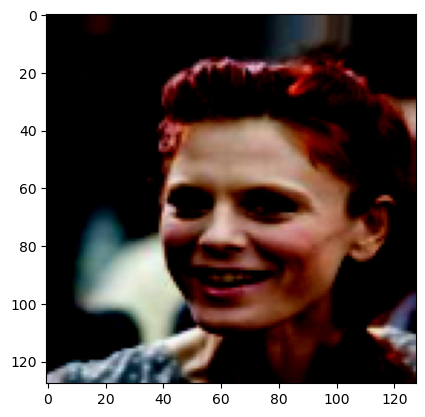

In [10]:
ds = face_dataset2()
print(len(ds))
img1 = ds[1]
plt.imshow(img1.numpy().transpose(1,2,0))


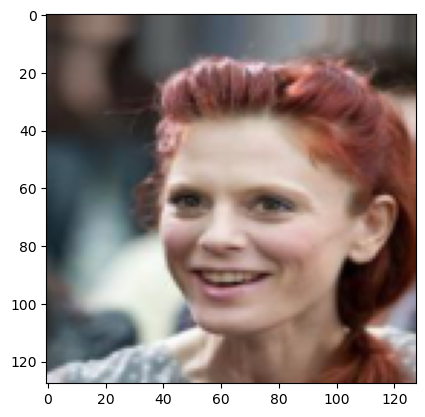

In [11]:
plt.imshow(np.transpose(torchvision.utils.make_grid(img1[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [12]:
batch_size = 128
num_samples = 160000
sampler = RandomSampler(ds,replacement=False,num_samples=num_samples)
dataloader = DataLoader(ds,batch_size,sampler=sampler)
len(dataloader)

1250

In [59]:
real_batch = next(iter(dataloader))
real_batch.shape

torch.Size([128, 3, 64, 64])

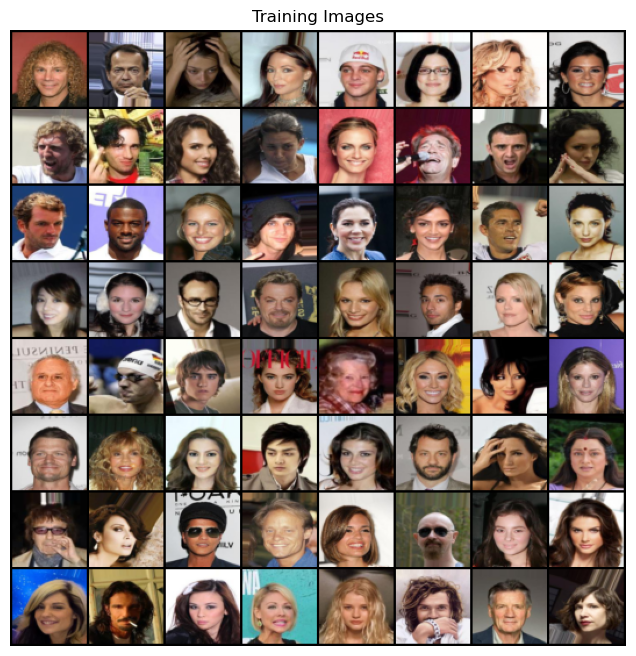

In [60]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# training routine

In [13]:
true_label = 0.95
false_label = 0.05
def train_discriminator(discriminator,fake_data,real_data,loss_fn,optimizer):
    optimizer.zero_grad()
    pred_fake = discriminator(fake_data)
    loss_fake = loss_fn(pred_fake,torch.full(size=(len(fake_data),1),fill_value=false_label).to(device))
    loss_fake.backward()
    pred_real = discriminator(real_data)
    loss_real = loss_fn(pred_real,torch.full(size=(len(real_data),1),fill_value=true_label).to(device))
    loss_real.backward()
    optimizer.step()
    return loss_real, loss_fake

In [14]:
def train_generator(discriminator, fake_data, loss_fn, optimizer):
    optimizer.zero_grad()
    pred = discriminator(fake_data)
    loss = loss_fn(pred,torch.full(size=(len(fake_data),1),fill_value=true_label).to(device))
    loss.backward()
    optimizer.step()
    return loss

In [15]:
def noise_generator(batch_size=128,noise_dim=1024):
    return torch.randn((batch_size,noise_dim)).to(device)

In [16]:
model_name = "simpleGAN"
if not os.path.exists(model_name):
    os.makedirs(model_name)

In [17]:
beta1 = 0.5
beta2 = 0.999
loss_fn = torch.nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=2e-4,betas=(beta1,beta2))
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=2e-4,betas=(beta1,beta2))

EPOCH: 1.000  d_loss: 0.967  g_loss: 3.279  (249.70s - 2746.65s remaining)
EPOCH: 2.000  d_loss: 0.880  g_loss: 2.763  (503.84s - 2519.21s remaining)


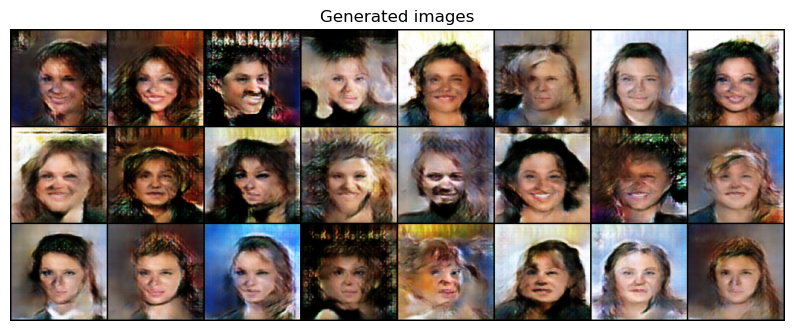

EPOCH: 3.000  d_loss: 0.918  g_loss: 2.296  (754.08s - 2262.24s remaining)
EPOCH: 4.000  d_loss: 0.919  g_loss: 2.156  (1001.57s - 2003.13s remaining)


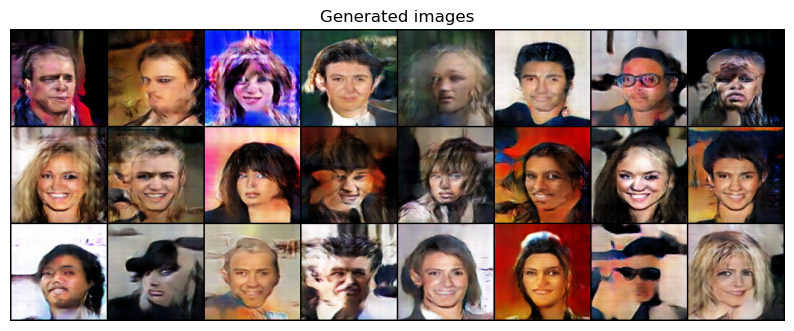

EPOCH: 5.000  d_loss: 0.895  g_loss: 2.196  (1251.37s - 1751.92s remaining)
EPOCH: 6.000  d_loss: 0.828  g_loss: 2.387  (1501.98s - 1501.98s remaining)


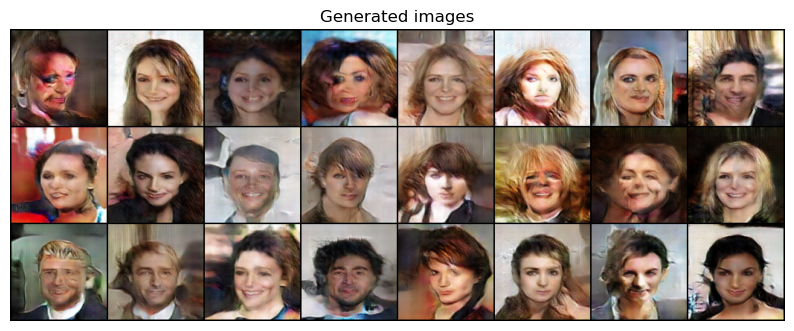

EPOCH: 7.000  d_loss: 0.784  g_loss: 2.562  (1746.97s - 1247.84s remaining)
EPOCH: 8.000  d_loss: 0.725  g_loss: 2.677  (1989.76s - 994.88s remaining))


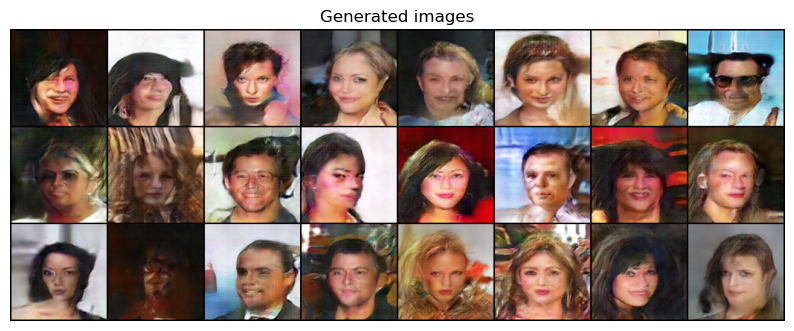

EPOCH: 9.000  d_loss: 0.698  g_loss: 2.741  (2233.19s - 744.40s remaining)
EPOCH: 10.000  d_loss: 0.664  g_loss: 2.797  (2471.51s - 494.30s remaining)


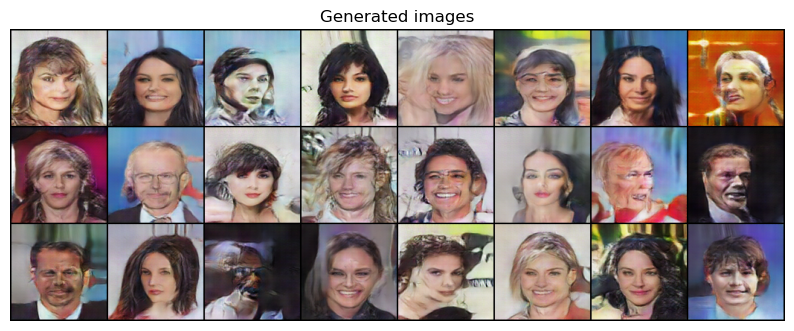

EPOCH: 11.000  d_loss: 0.634  g_loss: 2.976  (2710.01s - 246.36s remaining)
EPOCH: 12.000  d_loss: 0.624  g_loss: 2.942  (2948.72s - 0.00s remaining)))


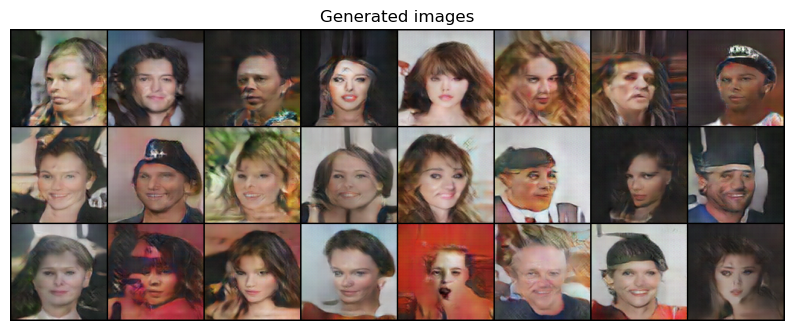

100%|██████████| 113/113 [00:00<00:00, 350.22it/s]


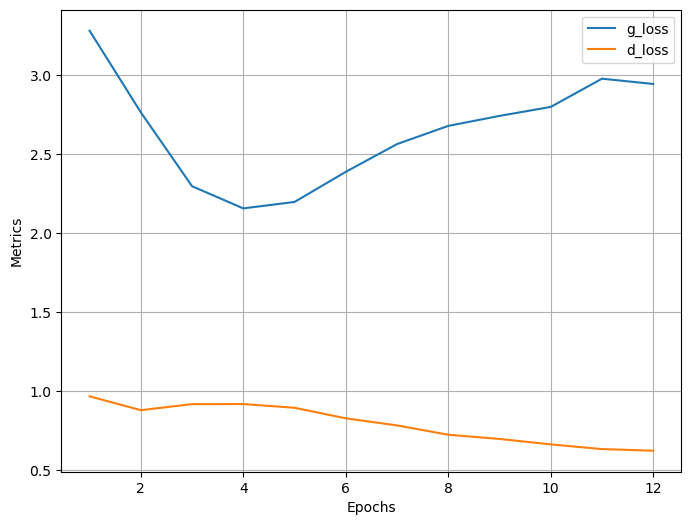

In [18]:
N = len(dataloader)
num_epochs =12
log = Report(num_epochs)
repeat_generator=1
noise_dim = 100
batch_size = 128
record_every = 1
show_every = 2
normalize = True


for epoch in range(num_epochs):
    for idx, imgs in enumerate(dataloader):
        real_data = imgs.to(device)
        fake_data = generator(noise_generator(batch_size,noise_dim).to(device))
        fake_data = fake_data.detach()
        real_loss, fake_loss = train_discriminator(discriminator,fake_data,real_data,loss_fn,d_optimizer)
        real_loss, fake_loss = real_loss.item(), fake_loss.item()
        d_total = real_loss + fake_loss
        g_total = 0
        g_batch = 0
        #while g_avg >= 3:
        for i in range(repeat_generator):
            fake_data = generator(noise_generator(batch_size,noise_dim).to(device))
            g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
            g_total += g_loss.item()

        log.record(epoch+(idx+1)/N,g_loss = g_total, d_loss = d_total, end='\r')
    if (epoch+1)%record_every  == 0:
        log.report_avgs(epoch+1)
    if (epoch+1)%show_every == 0:
        torch.save(generator.state_dict(),model_name+r'/generator.pth')
        torch.save(discriminator.state_dict(),model_name+r"/discriminator.pth")
        generator.eval()
        noise = torch.randn(24, noise_dim, device=device)
        sample_images = generator(noise).detach().cpu()
        grid = torchvision.utils.make_grid(sample_images, nrow=8, normalize=normalize)
        show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')
log.plot_epochs(['g_loss','d_loss'])

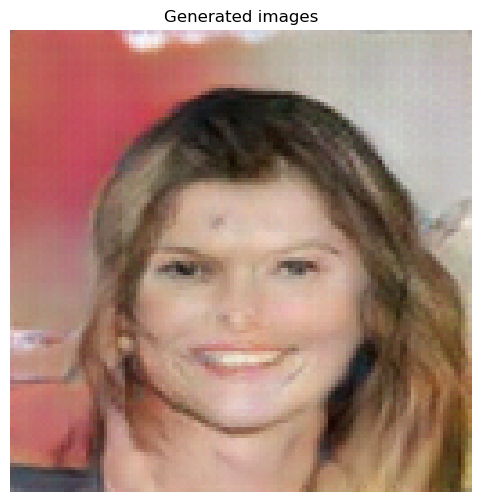

In [22]:
img = generator(noise_generator(batch_size=1,noise_dim=100))
img = img.squeeze()
grid = torchvision.utils.make_grid(img, nrow=8, normalize=normalize)
show(grid.cpu().detach().permute(1,2,0), sz=6, title='Generated images')